# RMSE testing
Investigating RMSE and related metrics. Comparing also to raw forecasts.

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import scores
import flox
import matplotlib.pyplot as plt
test = ["2024_07", "2024_10", "2025_01", "2025_04", "2025_07"]
val = ["2024_06", "2024_09", "2024_12", "2025_03", "2025_06"]


# using test data
selected_months = test

name_of_test = "test_combined_lt"

# by default uses val, can set val = test to get another set of months
# need to also adjust the obs location
# this is generated in the 'large_rainfall_gauges.py' file
obs_path_AIFS = "/path/to/extracted_sites/all_test_AIFS.parquet"
obs_path_HRES = "/path/to/extracted_sites/all_test_HRES.parquet"

# Original models
#AIFS_path = "/path/to/model_output/AIFS/calibrated_months/calibrated_precip"
#HRES_path = "/path/to/model_output/HRES/calibrated_months/calibrated_precip"

AIFS_path = "/path/to/model_output/combined_lt/AIFS/calibrated_months/calibrated_precip"
HRES_path = "/path/to/model_output/combined_lt/HRES/calibrated_months/calibrated_precip"

paths = {"AIFS": AIFS_path, "HRES": HRES_path}

# Colours for visualisation (blue for AIFS, orange for HRES)
new_AIFS_colour = "#004E89"
old_AIFS_colour = "#8AC6D0"
new_HRES_colour = "#FF6B35"
old_HRES_colour = "#F7C59F"

In [4]:
%%capture
vals = {}
for model in ["AIFS","HRES"]:
    months = []
    for m_y in selected_months:
        monthly = xr.load_dataset(f"{paths[model]}_{m_y}.nc")
        months.append(monthly)
        #print(monthly)
    # some slight differences in meta data between older and new AIFS data
    valset = xr.combine_by_coords(months, combine_attrs="override")
    vals[model] = valset
vals["AIFS"], vals["HRES"] = xr.align(vals["AIFS"], vals["HRES"], join="inner")

Expected value function confirmed working. Not 100% sure on the percentile metric.

In [5]:
def expected_value(fcst_da):
    width = (
        fcst_da["threshold"]
        .diff("threshold")
        .assign_coords({"threshold": fcst_da["threshold"].values[:-1]})
    )
    mid = fcst_da["threshold"].isel(threshold=slice(None, -1)) + width * 0.5
    diff = fcst_da.diff(dim="threshold")
    if diff.mean() < 0:
        diff = -diff
    height = diff.assign_coords({"threshold": fcst_da["threshold"].values[:-1]})
    exp_val = (height * mid).sum("threshold", skipna=False)
    exp_val.attrs["units"] = fcst_da.attrs["units"]
    return exp_val


def get_percentile(fcst_da, q=0.5):
    target_prob = 1.0 - q
    
    p_upper = fcst_da
    p_lower = fcst_da.shift(threshold=-1)
    
    crossing_mask = (p_upper >= target_prob) & (p_lower < target_prob)
    
    t_upper = fcst_da["threshold"]
    t_lower = fcst_da["threshold"].shift(threshold=-1)
    
    p1 = p_upper.where(crossing_mask).sum("threshold")
    p2 = p_lower.where(crossing_mask).sum("threshold")
    t1 = t_upper.where(crossing_mask).sum("threshold")
    t2 = t_lower.where(crossing_mask).sum("threshold")
    

    fraction = (target_prob - p1) / (p2 - p1)
    result = t1 + (t2 - t1) * fraction
    

    lowest_prob = fcst_da.isel(threshold=0)
    result = result.where(lowest_prob >= target_prob, fcst_da["threshold"][0])
    

    highest_threshold_prob = fcst_da.isel(threshold=-1)
    max_threshold = fcst_da["threshold"][-1]
    result = result.where(highest_threshold_prob < target_prob, max_threshold)

    result.attrs["units"] = fcst_da.attrs.get("units", "")
    result.name = f"percentile_{int(q*100)}"
    
    return result

Calculate expected value for forecasts (from calibrated CDFs)

In [6]:
val_dfs = {}
for model in ["HRES","AIFS"]:
    fcast = vals[model]["probability_of_lwe_thickness_of_precipitation_amount_above_threshold"]
    expected_val = expected_value(fcast)
    val_dfs[model] = expected_val.to_dataframe(name="calibrated_forecast").reset_index()

Read in obs data and merge with forecasts. These obs already are joined with raw forecasts, performed in the `large_rainfall_gauges.py` script.

In [7]:
AIFS_obs = pd.read_parquet(obs_path_AIFS)
HRES_obs = pd.read_parquet(obs_path_HRES)
obs = {"AIFS":AIFS_obs, "HRES": HRES_obs}
obs["AIFS"]

for model in ["HRES","AIFS"]:
    obs[model] = obs[model].rename(columns={"lwe_thickness_of_precipitation_amount":"raw_forecast","lwe_thickness_of_precipitation_amount_observed":"observed"})
    obs[model] = obs[model].merge(val_dfs[model], left_on = ["time", "forecast_period","site_id"], right_on=["time", "forecast_period","site_id"])
    print(model, "matches:", len(obs["HRES"]))

HRES matches: 879866
AIFS matches: 879866


Make one dataframe containing call information.

In [8]:
all_obs = obs["AIFS"].merge(obs["HRES"], left_on = ["time", "forecast_period","site_id"], right_on=["time", "forecast_period","site_id"], suffixes=('_AIFS','_HRES'))
all_obs_f = all_obs[["time","forecast_period","site_id","raw_forecast_AIFS","observed_AIFS","calibrated_forecast_AIFS","raw_forecast_HRES","observed_HRES","calibrated_forecast_HRES"]]

## Comparing calibration characteristics

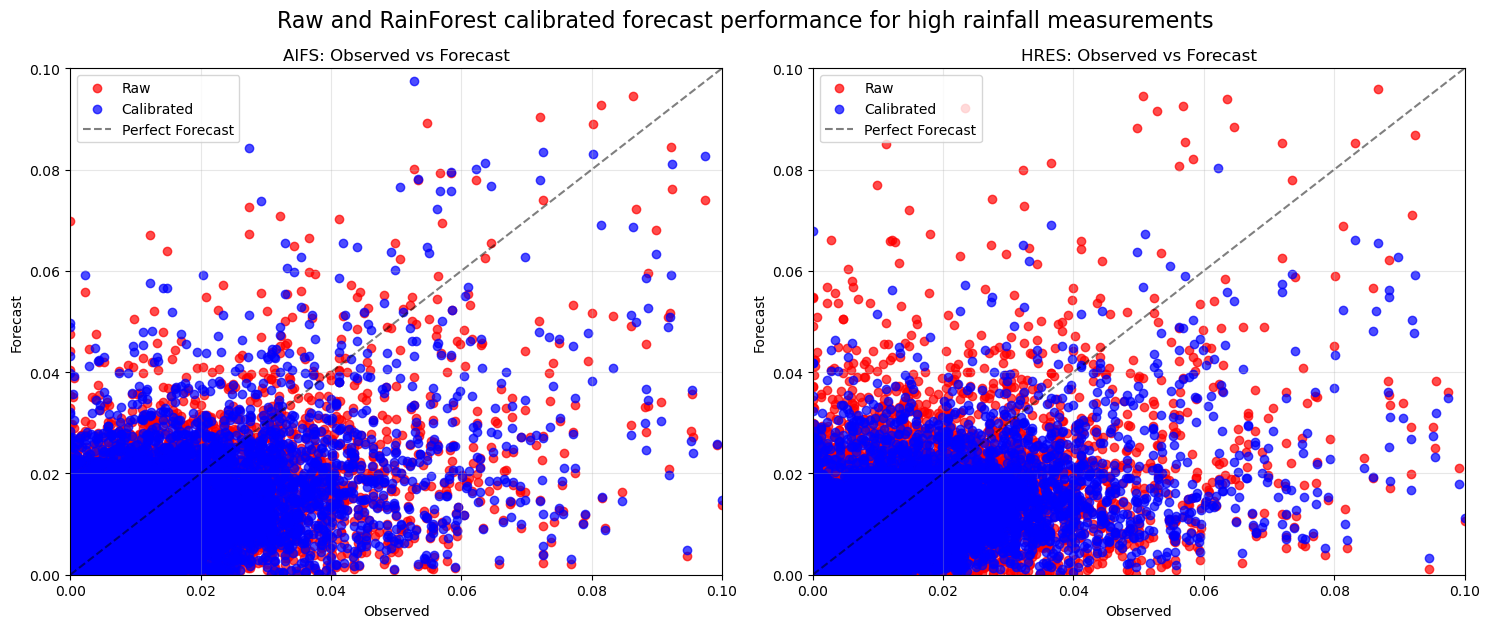

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df = all_obs_f[all_obs_f["forecast_period"] == pd.Timedelta(1,unit="d")]

lims = [
    0,
    0.1
]
# Plot AIFS
axes[0].scatter(df['observed_AIFS'], df['raw_forecast_AIFS'], label='Raw', color='red', alpha=0.7)
axes[0].scatter(df['observed_AIFS'], df['calibrated_forecast_AIFS'], label='Calibrated', color='blue', alpha=0.7)


# Plot HRES
axes[1].scatter(df['observed_HRES'], df['raw_forecast_HRES'], label='Raw', color='red', alpha=0.7)
axes[1].scatter(df['observed_HRES'], df['calibrated_forecast_HRES'], label='Calibrated', color='blue', alpha=0.7)


for i, model in enumerate(["AIFS","HRES"]):
    axes[i].plot(lims, lims, 'k--', alpha=0.5, label='Perfect Forecast')
    axes[i].set_title(f'{model}: Observed vs Forecast')
    axes[i].set_xlabel('Observed')
    axes[i].set_ylabel('Forecast')
    axes[i].legend()
    axes[i].set_xlim(lims[0],lims[1])
    axes[i].set_ylim(lims[0],lims[1])
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
fig.suptitle("Raw and RainForest calibrated forecast performance for high rainfall measurements", y=1.04, fontsize=16)
plt.savefig(f"{name_of_test}_large_rainfall_days.png")
plt.show()

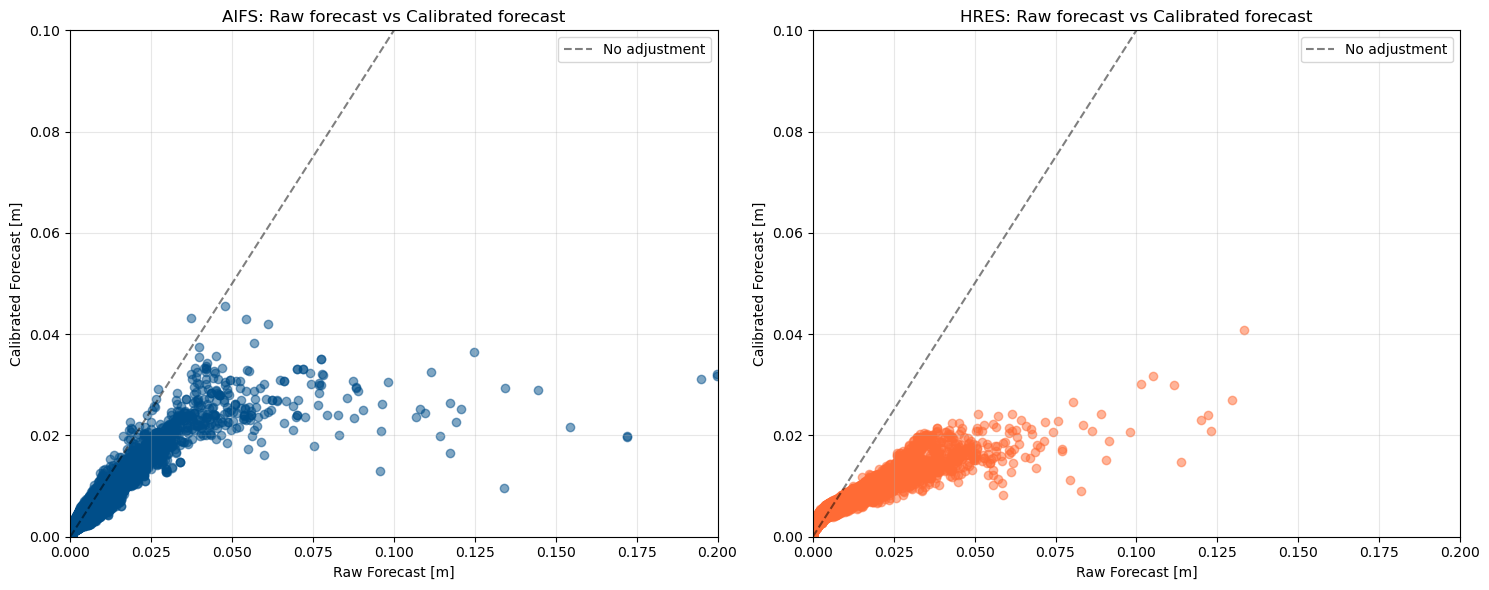

In [10]:
days = 8
all_obs_5d = all_obs_f[all_obs_f["forecast_period"] == pd.Timedelta(days,unit="d")]
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df = all_obs_5d

lims = [
    0,
    0.2
]
# Plot AIFS
axes[0].scatter(df['raw_forecast_AIFS'], df['calibrated_forecast_AIFS'], color=new_AIFS_colour, alpha=0.5)
# axes[0].scatter(df['observed_AIFS'], df['calibrated_forecast_AIFS'], label='Calibrated', color='blue', alpha=0.7)


# Plot HRES
axes[1].scatter(df['raw_forecast_HRES'], df['calibrated_forecast_HRES'], color=new_HRES_colour, alpha=0.5)
#axes[1].scatter(df['observed_HRES'], df['calibrated_forecast_HRES'], label='Calibrated', color='blue', alpha=0.7)


for i, model in enumerate(["AIFS","HRES"]):
    axes[i].plot(lims, lims, 'k--', alpha=0.5, label='No adjustment')
    axes[i].set_title(f'{model}: Raw forecast vs Calibrated forecast')
    axes[i].set_xlabel('Raw Forecast [m]')
    axes[i].set_ylabel('Calibrated Forecast [m]')
    axes[i].legend()
    axes[i].set_xlim(lims[0],lims[1])
    axes[i].set_ylim(lims[0],0.1)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
# fig.suptitle("Raw and RainForest calibrated forecast performance for high rainfall measurements (10 day lead time)", y=1.04, fontsize=16)
plt.savefig(f"{name_of_test}_rainfall_days_{days}day.png", bbox_inches='tight', dpi=300) 
plt.show()

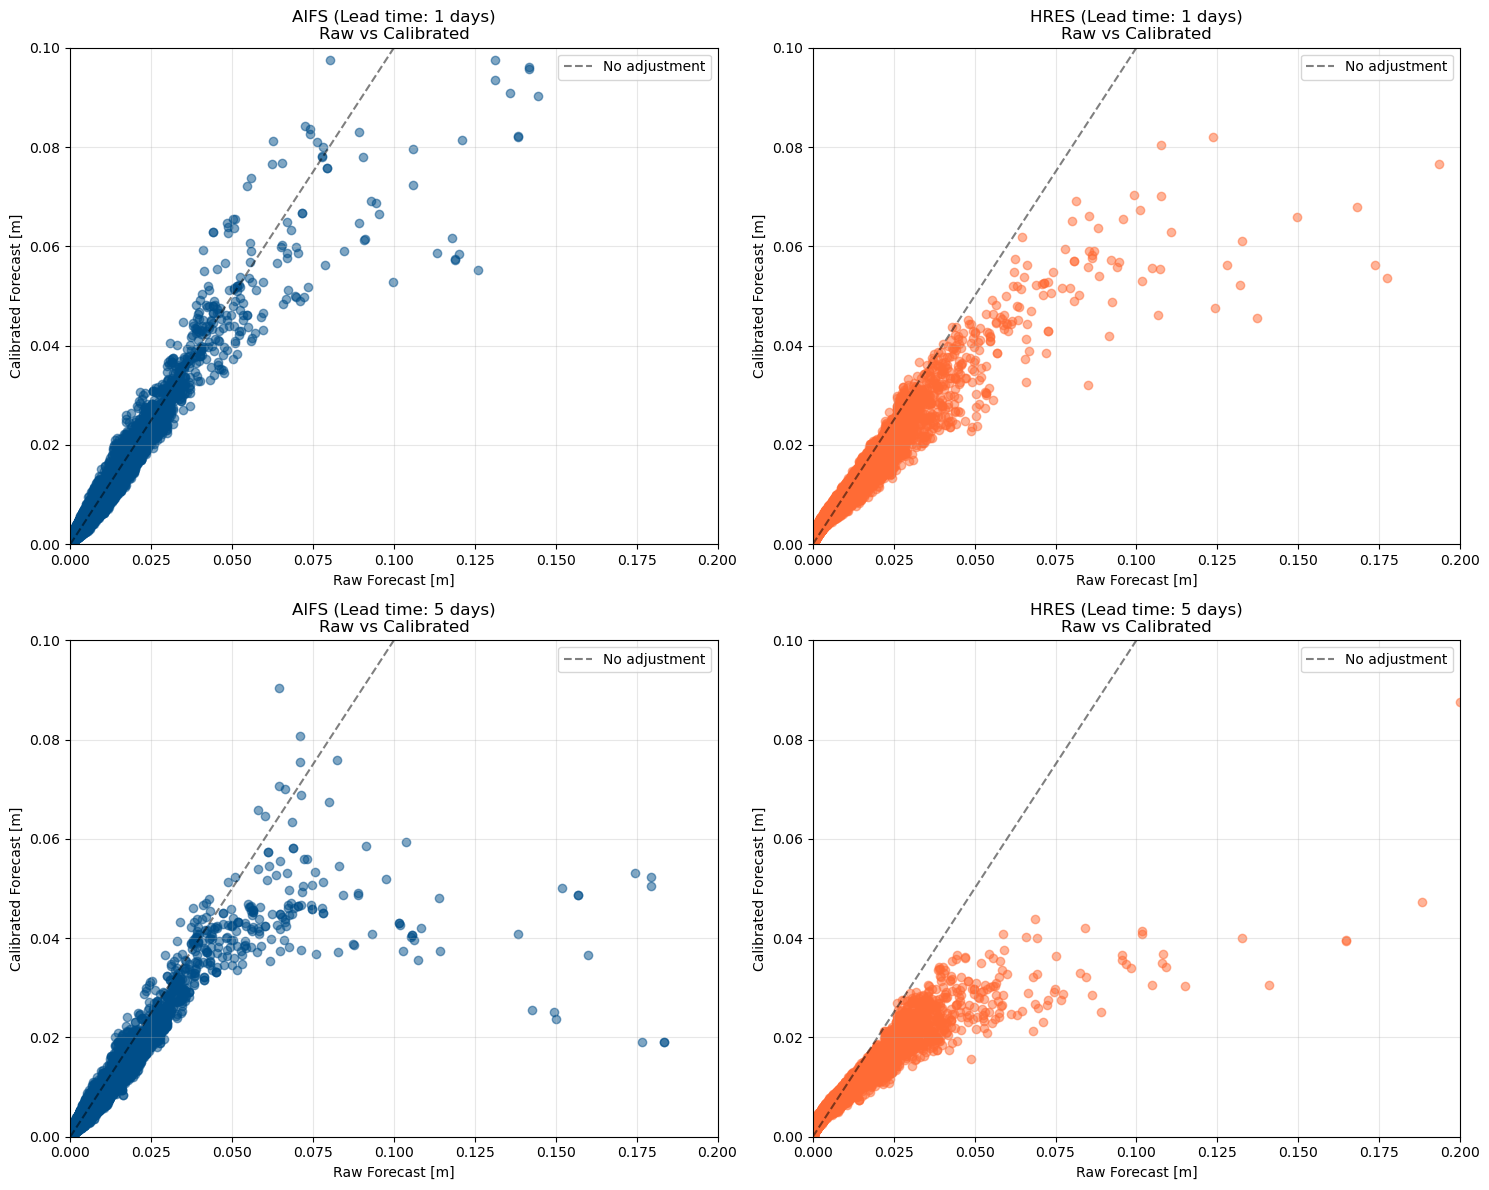

In [13]:
# Define the rows we want (1 day and 5 days)
target_days = [1, 5]
models = ["AIFS", "HRES"]
# Map your colors to the models
model_colors = {"AIFS": new_AIFS_colour, "HRES": new_HRES_colour}

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

lims = [0, 0.2]

# Loop through rows (days) and columns (models)
for row_idx, days in enumerate(target_days):
    # Filter data for the specific day (1 or 5)
    df = all_obs_f[all_obs_f["forecast_period"] == pd.Timedelta(days, unit="d")]
    
    for col_idx, model in enumerate(models):
        ax = axes[row_idx, col_idx]
        
        # Select data columns
        x_data = df[f'raw_forecast_{model}']
        y_data = df[f'calibrated_forecast_{model}']
        color = model_colors[model]
        
        # Plot Scatter
        ax.scatter(x_data, y_data, color=color, alpha=0.5)
        
        # Plot Identity Line (No adjustment)
        ax.plot(lims, lims, 'k--', alpha=0.5, label='No adjustment')
        
        # Styling
        ax.set_title(f'{model} (Lead time: {days} days)\nRaw vs Calibrated')
        ax.set_xlabel('Raw Forecast [m]')
        ax.set_ylabel('Calibrated Forecast [m]')
        
        ax.set_xlim(lims[0], lims[1])
        # Preserving your original y-limit logic
        ax.set_ylim(lims[0], 0.1) 
        
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("calibration_2x2.png", dpi=300)
plt.show()

In [37]:
# calculate RMSE
%%capture
import numpy as np

df = all_obs_f

# calulate RMSE
df['sq_err_AIFS_raw'] = (df['raw_forecast_AIFS'] - df['observed_AIFS'])**2
df['sq_err_AIFS_cal'] = (df['calibrated_forecast_AIFS'] - df['observed_AIFS'])**2
df['sq_err_HRES_raw'] = (df['raw_forecast_HRES'] - df['observed_HRES'])**2
df['sq_err_HRES_cal'] = (df['calibrated_forecast_HRES'] - df['observed_HRES'])**2

#  group by on lead time (taking the mean)
rmse_by_lead = (
    df
    .groupby("forecast_period")
    .agg(
        AIFS_raw=('sq_err_AIFS_raw', 'mean'),
        AIFS_calibrated=('sq_err_AIFS_cal', 'mean'),
        HRES_raw=('sq_err_HRES_raw', 'mean'),
        HRES_calibrated=('sq_err_HRES_cal', 'mean')
    )
    .apply(np.sqrt) # Apply sqrt to the final means
)

In [38]:
# calculate mean bias
df = all_obs_f

# Calculate errors
df['bias_AIFS_raw'] = (df['raw_forecast_AIFS'] - df['observed_AIFS'])
df['bias_AIFS_cal'] = (df['calibrated_forecast_AIFS'] - df['observed_AIFS'])
df['bias_HRES_raw'] = (df['raw_forecast_HRES'] - df['observed_HRES'])
df['bias_HRES_cal'] = (df['calibrated_forecast_HRES'] - df['observed_HRES'])

# Get average bias 
bias_by_lead = (
    df
    .groupby("forecast_period")
    .agg(
       
        AIFS_raw=('bias_AIFS_raw', 'mean'),
        AIFS_calibrated=('bias_AIFS_cal', 'mean'),
         HRES_raw=('bias_HRES_raw', 'mean'),
        HRES_calibrated=('bias_HRES_cal', 'mean'),
        
    )
)

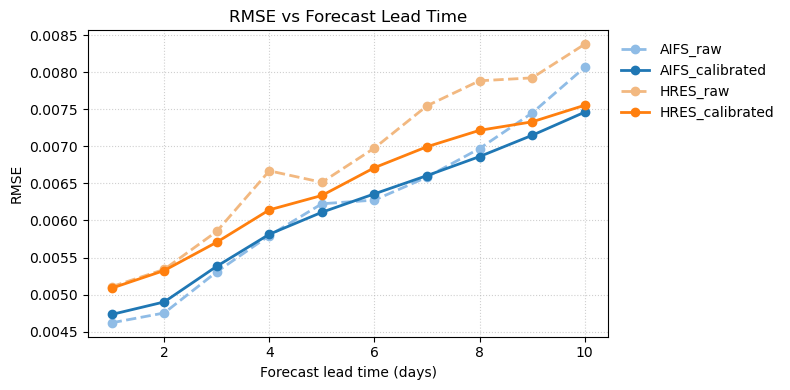

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

cols = rmse_by_lead.columns

pair_colours = [
    ["#8FBCE6", "tab:blue"],      # dark blue, light blue
    ["#F2B880","tab:orange"],    # dark orange, light orange
]

linestyles = ["--", "-"]

for i, col in enumerate(cols):
    pair = i // 2        # which pair (0 or 1)
    variant = i % 2     # within-pair (0 or 1)

    ax.plot(
        rmse_by_lead.index.days,
        rmse_by_lead[col],
        color=pair_colours[pair][variant],
        linestyle=linestyles[variant],
        marker="o",
        linewidth=2,
        label=col,
    )

ax.set_xlabel("Forecast lead time (days)")
ax.set_ylabel("RMSE")
ax.set_title("RMSE vs Forecast Lead Time")

ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.6)
ax.legend(frameon=False, bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig(f"{name_of_test}_testing_RMSE.png", dpi=300)
plt.show()


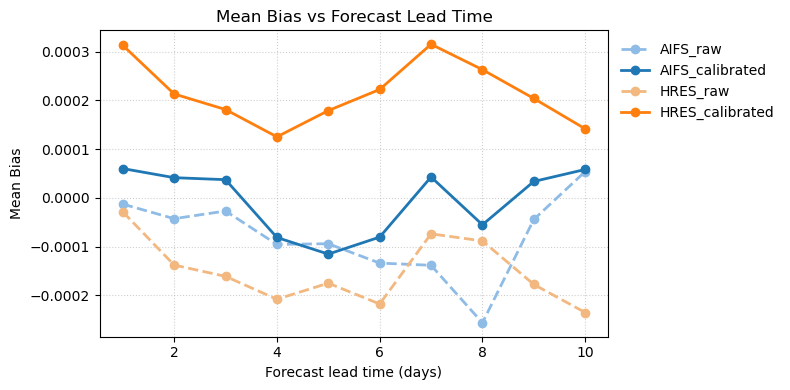

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

cols = bias_by_lead.columns

# Harmonised colour scheme
# Pair 1: blues (dark + light)
# Pair 2: oranges (dark + light)
pair_colours = [
    ["#8FBCE6", "tab:blue"],      # dark blue, light blue
    ["#F2B880","tab:orange"],    # dark orange, light orange
]

linestyles = ["--", "-"]

for i, col in enumerate(cols):
    pair = i // 2        # which pair (0 or 1)
    variant = i % 2     # within-pair (0 or 1)

    ax.plot(
        bias_by_lead.index.days,
        bias_by_lead[col],
        color=pair_colours[pair][variant],
        linestyle=linestyles[variant],
        marker="o",
        linewidth=2,
        label=col,
    )

ax.set_xlabel("Forecast lead time (days)")
ax.set_ylabel("Mean Bias")
ax.set_title("Mean Bias vs Forecast Lead Time")

ax.grid(True, linestyle=":", linewidth=0.8, alpha=0.6)
ax.legend(frameon=False, bbox_to_anchor=(1.00, 1.00))

plt.tight_layout()
plt.savefig(f"{name_of_test}_testing_mean_bias.png", dpi=300)
plt.show()


Index(['AIFS_raw', 'AIFS_calibrated', 'HRES_raw', 'HRES_calibrated'], dtype='object')
Index(['AIFS_raw', 'AIFS_calibrated', 'HRES_raw', 'HRES_calibrated'], dtype='object')


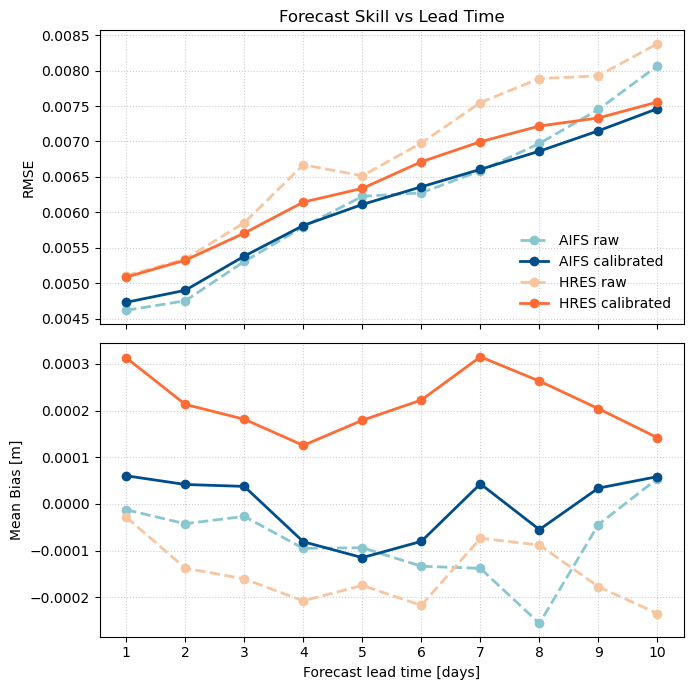

In [41]:
import matplotlib.pyplot as plt

fig, ( ax_rmse, ax_bias) = plt.subplots(
    2, 1, figsize=(8, 7), sharex=True
)

pair_colours = [
    [old_AIFS_colour, new_AIFS_colour], 
    [old_HRES_colour, new_HRES_colour],     
       
]

linestyles = ["--", "-"]


# ---- RMSE ----
cols = rmse_by_lead.columns
print(cols)
for i, col in enumerate(cols):
    pair = i // 2
    variant = i % 2

    ax_rmse.plot(
        rmse_by_lead.index.days,
        rmse_by_lead[col],
        color=pair_colours[pair][variant],
        linestyle=linestyles[variant],
        marker="o",
        linewidth=2,
        label=col,
    )

ax_bias.set_xlabel("Forecast lead time [days]")
ax_rmse.set_ylabel("RMSE")
ax_rmse.grid(True, linestyle=":", linewidth=0.8, alpha=0.6)
ax_rmse.set_title("Forecast Skill vs Lead Time")

# ---- Mean Bias ----
cols = bias_by_lead.columns
print(cols)
for i, col in enumerate(cols):
    pair = i // 2
    variant = i % 2

    ax_bias.plot(
        bias_by_lead.index.days,
        bias_by_lead[col],
        color=pair_colours[pair][variant],
        linestyle=linestyles[variant],
        marker="o",
        linewidth=2,
        label=col,
    )

ax_bias.set_ylabel("Mean Bias [m]")

ax_bias.grid(True, linestyle=":", linewidth=0.8, alpha=0.6)
ax_bias.set_xticks(range(1,11))

# ---- Single legend ----
handles, labels = ax_bias.get_legend_handles_labels()
ax_rmse.legend(
    handles,
    ["AIFS raw", "AIFS calibrated", "HRES raw", "HRES calibrated"],
    frameon=False,
    loc="lower right",
)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig(f"{name_of_test}_testing_bias_rmse.png", dpi=300)
plt.show()



# Investigating how different threshold levels were changed between forecasts

In [42]:
change_HRES = all_obs_f["calibrated_forecast_HRES"] - all_obs_f["raw_forecast_HRES"]
change_AIFS = all_obs_f["calibrated_forecast_AIFS"] - all_obs_f["raw_forecast_AIFS"]

In [43]:
bins = [0, 1e-4, 1e-3, 1e-2, 5e-2, 0.1, 0.3, 0.5]
bin_labels = [
    "0–0.0001",
    "0.0001–0.001",
    "0.001–0.01",
    "0.01–0.05",
    "0.05–0.1",
    "0.1–0.3",
    "0.3–0.5",
]
counts = {}
for model in ["HRES","AIFS"]:
    
    all_obs_f[f"rain_bin_{model}"] = pd.cut(
        all_obs_f[f"observed_{model}"],  # or observed_AIFS / raw forecast
        bins=bins,
        labels=bin_labels,
        include_lowest=True,
    )
    
    all_obs_f[f"change_{model}"] = (
        all_obs_f[f"calibrated_forecast_{model}"]
        - all_obs_f[f"raw_forecast_{model}"]
    )
    
    change = all_obs_f[f"change_{model}"]
    baseline = all_obs_f[f"raw_forecast_{model}"].abs()
    
    rel_tol = 0.5
    abs_tol = 1e-6
    
    tol = np.maximum(rel_tol * baseline, abs_tol)
    
    all_obs_f[f"{model}_direction"] = np.where(
        change > tol, "increase",
        np.where(change < -tol, "decrease", "no_change")
    )
    
    counts[model] = (
        all_obs_f
        .groupby([f"rain_bin_{model}", f"{model}_direction"])
        .size()
        .unstack(fill_value=0)
    )

print(counts["HRES"])
print(counts["AIFS"])

/jobfs/158759568.gadi-pbs/ipykernel_2926882/2923581450.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([f"rain_bin_{model}", f"{model}_direction"])


HRES_direction  decrease  increase  no_change
rain_bin_HRES                                
0–0.0001            1228    541953      29758
0.0001–0.001         744    116198      21755
0.001–0.01          1551     68547      50765
0.01–0.05           1416     13461      29561
0.05–0.1             197       463       1554
0.1–0.3              112       116        468
0.3–0.5                7         2         10
AIFS_direction  decrease  increase  no_change
rain_bin_AIFS                                
0–0.0001           19644    405889     147406
0.0001–0.001        1548     84308      52841
0.001–0.01           772     37763      82328
0.01–0.05            419      7063      36956
0.05–0.1             129       230       1855
0.1–0.3              113        46        537
0.3–0.5                6         1         12


/jobfs/158759568.gadi-pbs/ipykernel_2926882/2923581450.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([f"rain_bin_{model}", f"{model}_direction"])


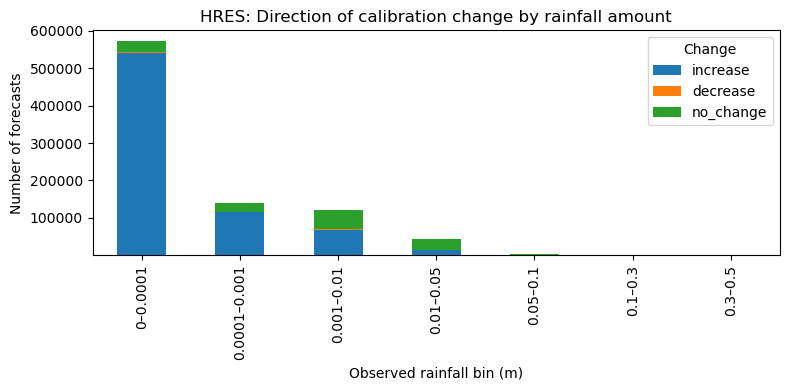

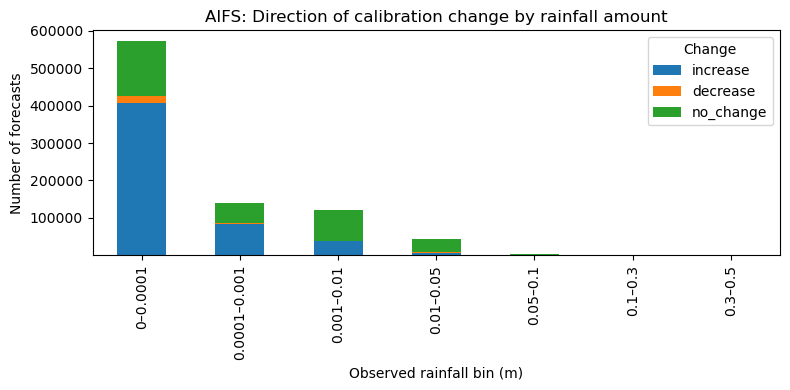

In [44]:
import matplotlib.pyplot as plt

for model in ["HRES","AIFS"]:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    counts[model][["increase", "decrease","no_change"]].plot(
        kind="bar",
        stacked=True,
        ax=ax,
    )
    
    ax.set_xlabel("Observed rainfall bin (m)")
    ax.set_ylabel("Number of forecasts")
    ax.set_title(f"{model}: Direction of calibration change by rainfall amount")
    ax.legend(title="Change")
    
    plt.tight_layout()
    plt.show()


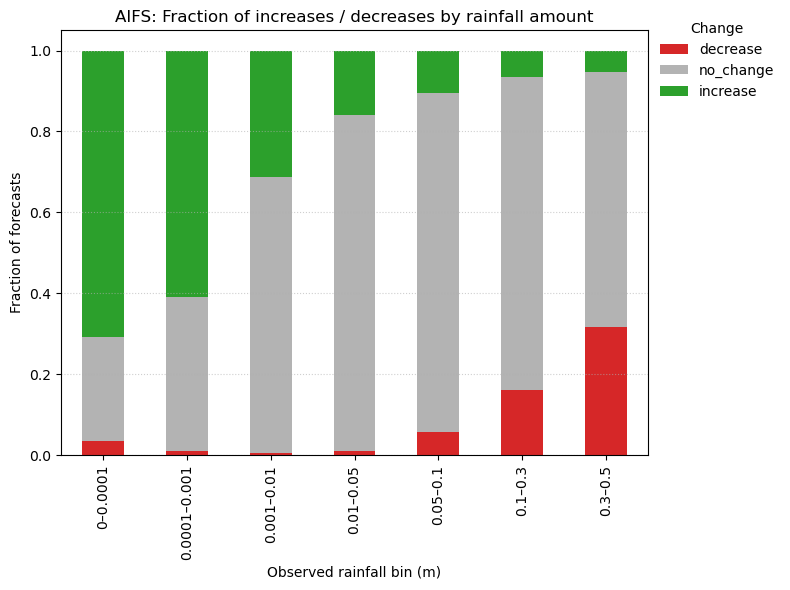

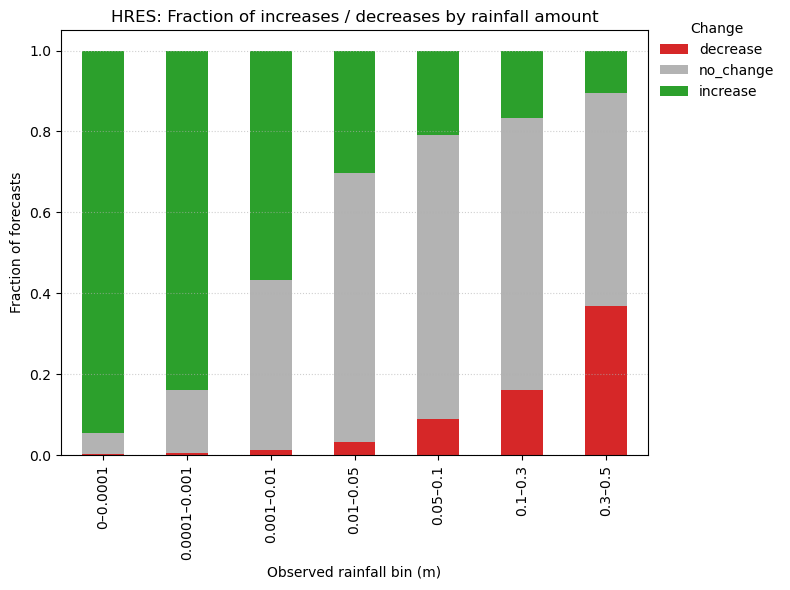

In [46]:
for model in ["AIFS","HRES"]:
    counts_HRES_prop = counts[model].div(
        counts[model]
            .sum(axis=1), axis=0
    )
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    counts_HRES_prop[["decrease", "no_change", "increase"]].plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=["tab:red", "0.7", "tab:green"],  # increase, decrease, no change
        edgecolor="black",
        linewidth=0.0,
    )
    
    ax.set_xlabel("Observed rainfall bin (m)")
    ax.set_ylabel("Fraction of forecasts")
    ax.set_title(f"{model}: Fraction of increases / decreases by rainfall amount")
    
    ax.legend(
        title="Change",
        frameon=False,
        bbox_to_anchor=(1.0, 1.05)
    )
    
    ax.grid(axis="y", linestyle=":", alpha=0.6)
    
    plt.tight_layout()
    plt.show()

